# Plan and Execute

> - 참고 자료: https://wikidocs.net/270688
> - 관련 논문: https://arxiv.org/abs/2305.04091

Plan-and-Execute 에이전트는 먼저 달성할 목표를 구체적인 단계로 나누어 계획을 수립한 뒤, 그 계획을 순차적으로 실행하며 실행 과정에서 얻은 피드백을 반영해 동적으로 조정하는 구조를 갖추고 있습니다.

[ReAct](https://arxiv.org/abs/2210.03629) 에이전트는 사고와 행동을 매 단계 즉시 교차 실행하며 즉각적 피드백에 대응하는 반면, Plan-and-Execute 에이전트는 전체 목표를 세부 단계별로 계획 수립 후 순차 실행하며 피드백으로 계획을 동적으로 조정합니다.

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 에이전트 정의

랭그래프에 사전 정의된 `create_react_agent`를 사용하여 ReAct 에이전트를 생성합니다.

In [11]:
from langgraph.prebuilt import create_react_agent
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=3)

agent_executor = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[web_search_tool],
    prompt="당신은 언제나 친절하고 능숙하게 지원을 제공하며, 사용자의 목표 달성을 돕는 탁월한 조수입니다.",
)

In [12]:
agent_executor.invoke({"messages": [("user", "랭그래프에 대해서 웹검색 해주세요.")]})

{'messages': [HumanMessage(content='랭그래프에 대해서 웹검색 해주세요.', additional_kwargs={}, response_metadata={}, id='a8421bec-c953-4275-974e-ca91ce7f07c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CLy03HjiDdZh8Imec5JEB8rc', 'function': {'arguments': '{"query":"랭그래프","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1311, 'total_tokens': 1335, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f245', 'id': 'chatcmpl-CP6IB82y7FkwtTZrdjbnDAeL2nr4L', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bd791a95-611a-4297-8aab-57ba10e74d97-0', tool_calls=[{'name': 'tavily_search', 'args': {'query':

## 상태 정의

In [13]:
from typing import TypedDict, Annotated
import operator


class State(TypedDict):
    input: Annotated[str, "사용자 요청"]
    plan: Annotated[list[str], "현재 계획"]
    past_steps: Annotated[list[tuple], operator.add]
    response: Annotated[str, "최종 응답"]

## 계획 노드

계획을 작성하는 노드를 작성합니다.

In [22]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class Plan(BaseModel):
    """계획 실행을 위한 단계별 분류"""

    steps: Annotated[
        list[str], Field(..., description="각 단계들은 정렬된 순서로 배치되어야 합니다")
    ]


def plan_node(state: State):
    system_prompt = (
        "목표를 달성하기 위해 간단한 단계별 계획을 세우세요."
        "각 단계 작업을 정확히 수행하면 정답이 도출되고 마지막 단계 결과가 최종 답안이 됩니다."
        "누락이나 중복 없이 필요한 정보만 포함하세요."
    )

    llm = ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0,
    ).with_structured_output(Plan)

    response = llm.invoke(
        [
            ("system", system_prompt),
            ("user", state["input"]),
        ]
    )
    return {"plan": response.steps}

In [23]:
plan_node(
    {"input": "LangGraph 의 핵심 장단점과 LangGraph 를 사용하는 이유는 무엇인가?"}
)

{'plan': ['LangGraph의 핵심 기능과 역할을 파악한다.',
  'LangGraph의 장점을 정리한다.',
  'LangGraph의 단점을 정리한다.',
  'LangGraph를 사용하는 이유를 명확히 설명한다.']}

## 재계획 노드

이전 결과를 바탕으로 계획을 다시 수립하는 노드를 작성합니다.

In [24]:
from typing import Union


class Response(BaseModel):
    """사용자에 대한 응답"""

    response: str


class Act(BaseModel):
    """수행할 작업"""

    action: Annotated[
        Union[Response, Plan],
        Field(
            ...,
            description="수행할 작업입니다."
            "사용자에게 응답하려면, Response를 사용합니다."
            "답을 얻기 위해 추가 도구가 필요하다면, Plan을 사용합니다.",
        ),
    ]


def replan_node(state: State):
    system_prompt_template = """목표 달성을 위한 단순 단계별 계획을 수립하세요.
계획은 각 과업으로 구분되며, 과업 이행 시 정답 도출이 가능해야 합니다. 불필요 과업은 배제합니다.
최종 과업의 산출물이 곧 최종 답안입니다. 단계 누락을 금하고, 모든 필수 정보를 포함하세요.

## 현재 정보

### 목표: 
{input}

### 기존 계획: 
{plan}

#### 이행 경과:
{past_steps}

계획을 갱신하되, 미완료 과업만 보강하세요. 
잔여 과업이 없으면 즉시 결과를 제시하세요."""

    llm = ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0,
    ).with_structured_output(Act)

    response = llm.invoke(
        [
            (
                "system",
                system_prompt_template.format(
                    input=state["input"],
                    plan=state["plan"],
                    past_steps=state["past_steps"],
                ),
            )
        ]
    )

    if isinstance(response.action, Response):
        return {"response": response.action.response}
    else:
        next_plan = response.action.steps
        if len(next_plan) > 0:
            return {"plan": next_plan}
        else:
            return {"response": "더 이상 단계가 필요하지 않습니다."}

## 실행 노드

주어진 작업을 수행하고 결과를 반환합니다.

In [32]:
def execute_node(state: State):
    prompt_template = (
        """다음 계획:{plan}\n\n당신은 [1단계. {task}]를 수행해야 합니다."""
    )

    plan = state["plan"]
    task = plan[0]

    response = agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    prompt_template.format(
                        plan="\n".join(
                            f"{i + 1}. {step}" for i, step in enumerate(plan)
                        ),
                        task=task,
                    ),
                )
            ],
        }
    )

    return {
        "past_steps": [
            (
                task,
                response["messages"][-1].content,
            )
        ]
    }

## 리포트 생성

작업 내용을 바탕으로 리포트를 작성합니다.

In [33]:
def generate_report_node(state: State):
    system_prompt_template = """당신에게는 목표와 이전에 수행된 단계들이 주어졌습니다. 
당신의 임무는 최종 보고서를 마크다운 형식으로 생성하는 것입니다.
최종 보고서는 전문적인 어조로 작성해야 합니다.

## 목표:

{input}

## 이전에 수행된 단계(질문과 답변 쌍):

{past_steps}

## 형식:

마크다운 형식으로 최종 보고서를 생성하세요."""

    past_steps = "\n\n".join(
        [
            f"요청: {request}\n\n응답: {response}\n\n####"
            for (request, response) in state["past_steps"]
        ]
    )

    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

    response = llm.invoke(
        [
            (
                "system",
                system_prompt_template.format(
                    input=state["input"],
                    past_steps=past_steps,
                ),
            )
        ]
    )

    return {"response": response.content}


## 그래프 생성

In [ ]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import InMemorySaver


def should_continue(state: State):
    if state.get("response"):
        return "generate_report"
    else:
        return "execute"


builder = StateGraph(State)
builder.add_node(plan_node)
builder.add_node(replan_node)
builder.add_node(execute_node)
builder.add_node(generate_report_node)

builder.add_edge(plan_node.__name__, execute_node.__name__)
builder.add_edge(execute_node.__name__, replan_node.__name__)
builder.add_conditional_edges(
    replan_node.__name__,
    should_continue,
    {
        "generate_report": generate_report_node.__name__,
        "execute": execute_node.__name__,
    },
)

builder.set_entry_point(plan_node.__name__)
builder.set_finish_point(generate_report_node.__name__)

graph = builder.compile(checkpointer=InMemorySaver())

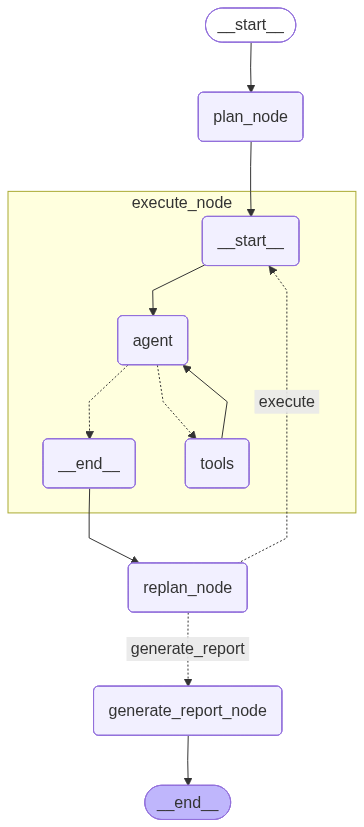

In [35]:
from IPython.display import display, Image

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## 그래프 실행

In [ ]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=50,
    configurable={
        "thread_id": "1",
    },
)

inputs = {
    "input": "Adaptive RAG가 Agentic Rag와 어떤 차이가 있는지 production level 에서 사용하는 이점을 위주로 설명해주세요."
}

for event in graph.stream(inputs, config=config, stream_mode="updates"):
    for key, values in event.items():
        print(f"\n=== {key} ===")
        pprint(values)


=== plan_node ===
{'plan': ['Adaptive RAG와 Agentic RAG의 기본 개념과 구조를 정의한다.',
          '두 모델의 주요 차이점을 기술한다.',
          'Production level에서 Adaptive RAG가 가지는 이점을 구체적으로 설명한다.',
          'Agentic RAG와 비교하여 Adaptive RAG가 생산 환경에서 더 적합한 이유를 정리한다.']}

=== execute_node ===
{'past_steps': [('Adaptive RAG와 Agentic RAG의 기본 개념과 구조를 정의한다.',
                 'Adaptive RAG와 Agentic RAG의 기본 개념과 구조에 대해 정의해 드리겠습니다.\n'
                 '\n'
                 '1. Adaptive RAG (Retrieval-Augmented Generation)\n'
                 '- 개념: Adaptive RAG는 외부 지식을 동적으로 검색하고 이를 생성 모델에 적응적으로 통합하는 '
                 '방식의 모델입니다. 즉, 쿼리나 상황에 따라 필요한 정보를 검색(리트리벌)하고, 그 정보를 토대로 텍스트를 '
                 '생성(제네레이션)하는 과정에서 적응성을 가집니다.\n'
                 '- 구조: 일반적으로 Adaptive RAG는 크게 세 부분으로 구성됩니다. 첫째, 쿼리 인코더가 입력 '
                 '질문을 벡터 공간에 임베딩합니다. 둘째, 벡터 데이터베이스에서 관련 문서를 검색하는 리트리벌 모듈이 '
                 '작동합니다. 셋째, 검색된 문서들과 쿼리를 기반으로 생성기가 최종 응답을 생성합니다. 이 과정에서 생성 '
                 '모델은 검색된 정보의 품질과 상황 변화에 맞춰 동적으로 반응하여 적합한 답변을 만듭

In [38]:
snapshot = graph.get_state(config)
snapshot.values

{'input': 'Adaptive RAG가 Agentic Rag와 어떤 차이가 있는지 production level 에서 사용하는 이점을 위주로 설명해주세요.',
 'plan': ['Production level에서 Adaptive RAG가 가지는 구체적인 이점을 기술한다.',
  'Agentic RAG와 비교하여 Adaptive RAG가 생산 환경에서 더 적합한 이유를 정리한다.',
  '최종적으로 Adaptive RAG가 Agentic RAG와 어떤 차이가 있으며, production level에서 Adaptive RAG를 사용하는 이점을 중심으로 종합 설명을 작성한다.'],
 'past_steps': [['Adaptive RAG와 Agentic RAG의 기본 개념과 구조를 정의한다.',
   'Adaptive RAG와 Agentic RAG의 기본 개념과 구조에 대해 정의해 드리겠습니다.\n\n1. Adaptive RAG (Retrieval-Augmented Generation)\n- 개념: Adaptive RAG는 외부 지식을 동적으로 검색하고 이를 생성 모델에 적응적으로 통합하는 방식의 모델입니다. 즉, 쿼리나 상황에 따라 필요한 정보를 검색(리트리벌)하고, 그 정보를 토대로 텍스트를 생성(제네레이션)하는 과정에서 적응성을 가집니다.\n- 구조: 일반적으로 Adaptive RAG는 크게 세 부분으로 구성됩니다. 첫째, 쿼리 인코더가 입력 질문을 벡터 공간에 임베딩합니다. 둘째, 벡터 데이터베이스에서 관련 문서를 검색하는 리트리벌 모듈이 작동합니다. 셋째, 검색된 문서들과 쿼리를 기반으로 생성기가 최종 응답을 생성합니다. 이 과정에서 생성 모델은 검색된 정보의 품질과 상황 변화에 맞춰 동적으로 반응하여 적합한 답변을 만듭니다.\n\n2. Agentic RAG\n- 개념: Agentic RAG는 에이전트(Agent)처럼 주도적으로 외부 지식을 탐색하고 활용하는 모델입니다. 단순히 검색과 생성 기능을 넘어서, 탐색 전략이나 의사결정 과정을 모델 내부에 내장

In [39]:
from IPython.display import Markdown, display

display(Markdown(snapshot.values["response"]))

# Adaptive RAG와 Agentic RAG의 생산 환경(Production Level) 적용 비교 및 Adaptive RAG의 이점

---

## 1. 서론

Retrieval-Augmented Generation(RAG) 기술은 외부 지식을 효과적으로 활용하여 자연어 생성 성능을 개선하는 혁신적인 접근법입니다. 그중 Adaptive RAG와 Agentic RAG는 각각 차별화된 설계 철학과 기능을 지니고 있으며, 실제 생산 환경에서의 적용 가치 또한 상이합니다. 본 보고서에서는 두 모델의 근본적인 차이점을 설명하고, 특히 생산 환경에서 Adaptive RAG가 제공하는 구체적인 이점을 중심으로 분석합니다.

---

## 2. Adaptive RAG vs Agentic RAG: 기본 개념 및 구조 차이

| 구분             | Adaptive RAG                                   | Agentic RAG                                     |
|------------------|-----------------------------------------------|------------------------------------------------|
| **개념**          | 입력 쿼리 및 상황에 따라 외부 지식 검색과 생성 과정을 적응적으로 조정하는 모델 | 에이전트 기반의 자율적 탐색 및 의사결정 기능을 내장하여 복합적인 태스크를 주도적으로 수행하는 모델 |
| **구조**          | 쿼리 인코더 → 동적 리트리벌 모듈 → 적응적 생성기 | 에이전트 구성요소 포함 (쿼리 생성, 리트리벌, 평가, 행동계획, 제어 모듈) |
| **작업 방식**      | 상황 변화에 따른 검색-생성 전략의 유연한 조절 | 에이전트 간 역할 분담 및 협력적 의사결정, 복잡한 작업 흐름 관리 |
| **목적**          | 다양한 도메인과 환경에 맞는 실시간 적응 및 정확한 정보 통합 | 복잡한 문제 해결을 위한 구조화된 분산 처리 및 전문성 강화 |

---

## 3. 주요 차이점 요약

- **적응성 vs 구조화**: Adaptive RAG는 검색 및 생성 프로세스를 실시간으로 조절하며 환경 변화에 민첩하게 대응하는 반면, Agentic RAG는 여러 에이전트가 분업하여 복잡한 작업을 구조적으로 수행합니다.
- **단일 프로세스 vs 다중 에이전트**: Adaptive RAG는 하나의 통합된 검색-생성 파이프라인에 집중하는 반면, Agentic RAG는 내부 에이전트들이 독립적이면서도 협력적으로 행동합니다.
- **적용 범위**: Adaptive RAG는 빠른 적응성과 유연성을 요구하는 일반적 정보 검색 및 생성 작업에 적합하며, Agentic RAG는 복합적인 의사결정 및 다단계 탐색이 필요한 상황에서 강점을 가집니다.

---

## 4. Production Level에서 Adaptive RAG의 구체적인 이점

Adaptive RAG는 생산 환경에서 다음과 같은 핵심적인 장점들을 제공합니다.

### 4.1 효율적인 정보 검색 및 생성 최적화

- 쿼리 유형과 맥락에 따라 리트리벌 및 생성 전략을 동적으로 조절함으로써 불필요한 데이터 검색과 계산을 최소화합니다.
- 이로 인해 응답 시간이 단축되고, 시스템 리소스 사용이 최적화되어 대규모 서비스 운영에 유리합니다.

### 4.2 높은 정확성과 신뢰성 확보

- 최신 데이터 및 문맥 정보를 반영하는 적응형 검색 덕분에, 출력되는 텍스트의 신뢰성과 품질이 향상됩니다.
- 다양한 도메인과 변화하는 환경에 신속히 적응하여 일관된 성능을 유지합니다.

### 4.3 뛰어난 확장성과 유지보수 용이성

- 모듈화된 검색·생성 구조와 동적 조정 기능으로, 비즈니스 요구사항 변화에 따라 손쉽게 전략을 수정하거나 확장할 수 있습니다.
- 유지보수 및 업데이트가 상대적으로 간단하여 운영 효율성을 증대합니다.

### 4.4 비용 효율성 증대

- 필요한 정보에 집중함으로써 불필요한 컴퓨팅 자원 낭비를 줄이고, 클라우드 비용 및 하드웨어 운용 비용 절감에 기여합니다.
- 효율적인 자원 배분으로 운영 비용 최적화가 가능합니다.

### 4.5 사용자 경험 및 서비스 신뢰성 향상

- 상황에 맞는 적절한 정보 제공으로 사용자 만족도가 높아지고, 서비스 품질이 강화됩니다.
- 실시간 데이터 변화에 신속히 대응하여 사용자 요구에 민첩하게 반응할 수 있습니다.

---

## 5. 결론

Adaptive RAG와 Agentic RAG는 각각의 설계 철학과 구조적 특징을 바탕으로 다양한 활용 가능성을 지니고 있습니다. 그러나 생산 환경에서의 적용 측면에서는 Adaptive RAG가 다음과 같은 이유로 더욱 적합하고 유리합니다.

- 신속한 환경 변화에 대응하는 높은 적응성과 유연성
- 효율적인 리소스 사용과 운영 비용 절감
- 유지보수 및 확장성 측면에서의 용이성
- 사용자 경험을 극대화하는 높은 신뢰성 및 정확성

따라서, 실시간 정보 제공, 대규모 데이터 처리, 다양한 도메인 대응이 요구되는 생산 환경에서 Adaptive RAG는 실용적이고 경쟁력 있는 선택지로 평가됩니다.

---

## 6. 참고 문헌 및 추가 자료

- Lewis et al., “Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks,” NeurIPS 2020.
- Recent advances in Retrieval-Augmented Generation architectures and applications.
- Production-level deployment case studies of Adaptive RAG systems.

---

# 끝.